# Bayesian GAN

Bayesian GAN (Saatchi and Wilson, 2017) is a Bayesian formulation of Generative Adversarial Networks (Goodfellow, 2014) where we learn the **distributions** of the generator parameters $\theta_g$ and the discriminator parameters $\theta_d$ instead of optimizing for point estimates. The benefits of the Bayesian approach include the flexibility to model **multimodality** in the parameter space, as well as the ability to **prevent mode collapse** in the maximum likelihood (non-Bayesian) case.


We learn Bayesian GAN via an approximate inference algorithm called **Stochastic Gradient Hamiltonian Monte Carlo (SGHMC)** which is a gradient-based MCMC methods whose samples approximate the true posterior distributions of $\theta_g$ and $\theta_d$.

The Bayesian GAN training process starts from sampling noise $z$ from a fixed distribution (typically standard d-dim normal).  The noise is fed to the generator where the parameters $\theta_g$ are sampled from the posterior distribution $p(\theta_g | D)$. The generated image given the parameters $\theta_g$ ($G(z|\theta_g)$) as well as the real data are presented to the discriminator, whose parameters are sample from its posterior distribution $p(\theta_d|D)$. We update the posteriors using the gradients $\frac{\partial \log p(\theta_g|D) }{\partial \theta_g }$ and $\frac{\partial \log p(\theta_d|D) }{\partial \theta_d }$ with Stochastic Gradient Hamiltonian Monte Carlo (SGHMC). Next section explains the intuition behind SGHMC.

![Bayesian GAN](figs/graphics_bayesgan.png)

<img src="figs/graphics_bayesgan.pdf">

# Learning Posterior Distributions 

There are many approaches to estimate the posterior distribution of model parameters, namely, Markov Chain Monte Carlo (MCMC), Variational Inference (VI), Approximate Bayesian Computation (ABC), etc. Bayesian GAN uses SGHMC (Chen, 2014), a stochastic version of HMC (Neal, 2012), which is an MCMC method that (1) uses gradient to perform sampling efficiently (2) stochastic gradient from minibatch to handle large amount of data. 

Below we show the visualization of samples generated from HMC. Once the algorithm runs for a while, we can see that the high density region has higher concentration of points. HMC can also handle multimodality (the second visualization).

In [1]:
from IPython.display import HTML
HTML('<iframe width="1000" height="400" src="https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana" frameborder="0" allowfullscreen></iframe>')

C:\Users\preet\anaconda3\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Hamiltonian Monte Carlo allows us to learn arbitrary distributions, including multimodal distributions where other Bayesian approach such as variational inference cannot model. 

In [2]:
HTML('<iframe width="1000" height="400" src="https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,multimodal" frameborder="0" allowfullscreen></iframe>')

# Training

We show that Bayesian GAN can capture the data distribution by measuring its performance in the semi-supervised setting. We will perform the posterior update as outline in Algorithm 1 in Saatchi (2017). This algorithm can be implemented quite simply by adding noise to standard optimizers such as SGD with momentum and keep track of the parameters we sample from the posterior. 

![Posterior Sampling Algorithm](figs/bgan_alg1.png)

### SGHMC by Optimizing a Noisy Loss

First, observe that the update rules are similar to momentum SGD except for the noise $\boldsymbol{n}$. In fact, without $\boldsymbol{n}$, this is equivalent to performing momentum SGD with the loss is $- \sum_{i=1}{J_g} \sum_{k=1}^{J_d} \log \text{posterior} $. We will describe the case where $J_g = J_d=1$ for simplicity. 

We use the main loss $\mathcal{L} = - \log p(\theta | ..)$ and add a noise loss $\mathcal{L}_\text{noise} = \frac{1}{\eta} \theta \cdot \boldsymbol{n}$ where $\boldsymbol{n} \sim \mathcal{N}(0, 2 \alpha \eta I)$ so that optimizing the loss function $\mathcal{L} + \mathcal{L}_\text{noise}$ with momentum SGD is equivalent to performing the SGHMC update step. 

Below (Equation 3 and 4) are the posterior probabilities where each error term corresponds its negative log probability.

![Posterior Distributions](figs/posterior_eqs2.png)

In [3]:
!pip install tensorboard_logger

In [4]:
from __future__ import print_function
import os, pickle
import numpy as np
import random, math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from statsutil import AverageMeter, accuracy
from tensorboard_logger import configure, log_value

In [5]:
# Default Parameters
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='cifar10')
parser.add_argument('--imageSize', type=int, default=32)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--niter', type=int, default=2, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--cuda', type=int, default=1, help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--outf', default='modelfiles/pytorch_demo3', help='folder to output images and model checkpoints')
parser.add_argument('--numz', type=int, default=1, help='The number of set of z to marginalize over.')
parser.add_argument('--num_mcmc', type=int, default=10, help='The number of MCMC chains to run in parallel')
parser.add_argument('--num_semi', type=int, default=4000, help='The number of semi-supervised samples')
parser.add_argument('--gnoise_alpha', type=float, default=0.0001, help='')
parser.add_argument('--dnoise_alpha', type=float, default=0.0001, help='')
parser.add_argument('--d_optim', type=str, default='adam', choices=['adam', 'sgd'], help='')
parser.add_argument('--g_optim', type=str, default='adam', choices=['adam', 'sgd'], help='')
parser.add_argument('--stats_interval', type=int, default=10, help='Calculate test accuracy every interval')
parser.add_argument('--tensorboard', type=int, default=1, help='')
parser.add_argument('--bayes', type=int, default=1, help='Do Bayesian GAN or normal GAN')
import sys; sys.argv=['']; del sys
opt = parser.parse_args()
try:
    if not os.path.exists(opt.outf):
        os.makedirs(opt.outf)
except OSError:
    print("Error Making Directory", opt.outf)
    pass
if opt.tensorboard: configure(opt.outf)

In [6]:
# First, we construct the data loader for full training set 
# as well as the data loader of a partial training set for semi-supervised learning
# transformation operator
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform_opt = transforms.Compose([
                               transforms.ToTensor(),
                               normalize,
                           ])
# get training set and test set
# dataset = dset.CIFAR10(root=os.environ['CIFAR10_PATH'], download=True,transform=transform_opt)  
dataset = dset.CIFAR10(root='./data', download=True,transform=transform_opt)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=1)

from partial_dataset import PartialDataset
# partial dataset for semi-supervised training
dataset_partial = PartialDataset(dataset, opt.num_semi)


# test set for evaluation
# dataset_test = dset.CIFAR10(root=os.environ['CIFAR10_PATH'], train=False, transform=transform_opt)
dataset_test = dset.CIFAR10(root='./data', train=False, transform=transform_opt)
dataloader_test = torch.utils.data.DataLoader(dataset_test,
                        batch_size=opt.batchSize, shuffle=False, pin_memory=True, num_workers=1)

dataloader_semi = torch.utils.data.DataLoader(dataset_partial, batch_size=opt.batchSize,
                                    shuffle=True, num_workers=1)

Files already downloaded and verified


In [7]:
# Now we initialize the distributions of G and D
##### Generator ######
# opt.num_mcmc is the number of MCMC chains that we run in parallel
# opt.numz is the number of noise batches that we use. We also use different parameter samples for different batches
# we construct opt.numz * opt.num_mcmc initial generator parameters
# We will keep sampling parameters from the posterior starting from this set
# Keeping track of many MCMC chains can be done quite elegantly in Pytorch
from models.discriminators import _netD
from models.generators import _netG
from statsutil import weights_init
netGs = []
for _idxz in range(opt.numz):
    for _idxm in range(opt.num_mcmc):
        netG = _netG(opt.ngpu, nz=opt.nz)
        netG.apply(weights_init)
        netGs.append(netG)
##### Discriminator ######
# We will use 1 chain of MCMCs for the discriminator
# The number of classes for semi-supervised case is 11; that is,
# index 0 for fake data and 1-10 for the 10 classes of CIFAR.
num_classes = 11
netD = _netD(opt.ngpu, num_classes=num_classes)

Initializing the Batch Norm layers. Affine = True


In [8]:
# In order to calculate errG or errD_real, we need to sum the probabilities over all the classes (1 to K)
# ComplementCrossEntropyLoss is a loss function that performs this task
# We can specify a default except_index that corresponds to a fake label. In this case, we use index=0
from ComplementCrossEntropyLoss import ComplementCrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# use the default index = 0 - equivalent to summing all other probabilities
criterion_comp = ComplementCrossEntropyLoss(except_index=0)


from models.distributions import Normal
from models.bayes import NoiseLoss, PriorLoss
# Finally, initialize the ``optimizers''
# Since we keep track of a set of parameters, we also need a set of
# ``optimizers''
if opt.d_optim == 'adam':
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(0.5, 0.999))
elif opt.d_optim == 'sgd':
    optimizerD = torch.optim.SGD(netD.parameters(), lr=opt.lr,
                                momentum=0.9,
                                nesterov=True,
                                weight_decay=1e-4)
optimizerGs = []
for netG in netGs:
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(0.5, 0.999))
    optimizerGs.append(optimizerG)

# since the log posterior is the average per sample, we also scale down the prior and the noise
gprior_criterion = PriorLoss(prior_std=1., observed=1000.)
gnoise_criterion = NoiseLoss(params=netGs[0].parameters(), scale=math.sqrt(2*opt.gnoise_alpha/opt.lr), observed=1000.)
dprior_criterion = PriorLoss(prior_std=1., observed=50000.)
dnoise_criterion = NoiseLoss(params=netD.parameters(), scale=math.sqrt(2*opt.dnoise_alpha*opt.lr), observed=50000.)

In [9]:
# Fixed noise for data generation
fixed_noise = torch.FloatTensor(opt.batchSize, opt.nz, 1, 1).normal_(0, 1).cuda()
fixed_noise = Variable(fixed_noise)

# initialize input variables and use CUDA (optional)
input = torch.FloatTensor(opt.batchSize, 3, opt.imageSize, opt.imageSize)
noise = torch.FloatTensor(opt.batchSize, opt.nz, 1, 1)
label = torch.FloatTensor(opt.batchSize)
real_label = 1
fake_label = 0

if opt.cuda:
    netD.cuda()
    for netG in netGs:
        netG.cuda()
    criterion.cuda()
    criterion_comp.cuda()
    input, label = input.cuda(), label.cuda()
    noise = noise.cuda()

In [10]:
# fully supervised
netD_fullsup = _netD(opt.ngpu, num_classes=num_classes)
netD_fullsup.apply(weights_init)
criterion_fullsup = nn.CrossEntropyLoss()
if opt.d_optim == 'adam':
    optimizerD_fullsup = optim.Adam(netD_fullsup.parameters(), lr=opt.lr, betas=(0.5, 0.999))
else:
    optimizerD_fullsup = optim.SGD(netD_fullsup.parameters(), lr=opt.lr,
                                momentum=0.9,
                                nesterov=True,
                                weight_decay=1e-4)
if opt.cuda:
    netD_fullsup.cuda()
    criterion_fullsup.cuda()

In [11]:
# We define a class to calculate the accuracy on test set
# to test the performance of semi-supervised training
def get_test_accuracy(model_d, iteration, label='semi'):
    # don't forget to do model_d.eval() before doing evaluation
    top1 = AverageMeter()
    for i, (input, target) in enumerate(dataloader_test):
        target = target.cuda()
        input = input.cuda()
        input_var = torch.autograd.Variable(input.cuda(), volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)
        output = model_d(input_var)

        probs = output.data[:, 1:] # discard the zeroth index
        prec1 = accuracy(probs, target, topk=(1,))[0]
#         top1.update(prec1[0], input.size(0))
        top1.update(prec1.item(), input.size(0))
        if i % 50 == 0:
              print("{} Test: [{}/{}]\t Prec@1 {top1.val:.3f} ({top1.avg:.3f})"\
                .format(label, i, len(dataloader_test), top1=top1))
    print('{label} Test Prec@1 {top1.avg:.2f}'.format(label=label, top1=top1))
    log_value('test_acc_{}'.format(label), top1.avg, iteration)

In [12]:
torch.autograd.set_detect_anomaly(True)

iteration = 0
for epoch in range(opt.niter):
    top1 = AverageMeter()
    top1_weakD = AverageMeter()
    for i, data in enumerate(dataloader):
        iteration += 1
        #######
        # 1. real input
        netD.zero_grad()
        _input, _ = data
        batch_size = _input.size(0)
        if opt.cuda:
            _input = _input.cuda()
        input.resize_as_(_input).copy_(_input)       
        label.resize_(batch_size).fill_(real_label)  
        inputv = Variable(input)
        labelv = Variable(label)
        
        output = netD(inputv)
        errD_real = criterion_comp(output)
        if errD_real is not None:
            errD_real.backward()
        # calculate D_x, the probability that real data are classified 
        D_x = 1 - torch.nn.functional.softmax(output).data[:, 0].mean()
        
        #######
        # 2. Generated input
        fakes = []
        for _idxz in range(opt.numz):
            noise.resize_(batch_size, opt.nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise)
            for _idxm in range(opt.num_mcmc):
                idx = _idxz*opt.num_mcmc + _idxm
                netG = netGs[idx]
                _fake = netG(noisev)
                fakes.append(_fake)
        fake = torch.cat(fakes)
        output = netD(fake.detach())
        labelv = Variable(torch.LongTensor(fake.data.shape[0]).cuda().fill_(fake_label))
        errD_fake = criterion(output, labelv)
        if errD_fake is not None:
            errD_fake.backward()
        
        D_G_z1 = 1 - torch.nn.functional.softmax(output).data[:, 0].mean()
        
        #######
        # 3. Labeled Data Part (for semi-supervised learning)
        for ii, (input_sup, target_sup) in enumerate(dataloader_semi):
            input_sup, target_sup = input_sup.cuda(), target_sup.cuda()
            break
        input_sup_v = Variable(input_sup.cuda())
        # convert target indicies from 0 to 9 to 1 to 10
        target_sup_v = Variable( (target_sup + 1).cuda())
        output_sup = netD(input_sup_v)
        err_sup = criterion(output_sup, target_sup_v)
        if err_sup is not None:
            err_sup.backward()
        prec1 = accuracy(output_sup.data, target_sup + 1, topk=(1,))[0]
#         print("prec1:", prec1)
#         top1.update(prec1[0], input_sup.size(0))
        top1.update(prec1.item(), input_sup.size(0))
        if opt.bayes:
            errD_prior = dprior_criterion(netD.parameters())
            if errD_prior is not None:
                errD_prior.backward()
            errD_noise = dnoise_criterion(netD.parameters())
            if errD_noise is not None:
                errD_noise.backward()
            errD = errD_real + errD_fake + err_sup + errD_prior + errD_noise
        else:
            errD = errD_real + errD_fake + err_sup
#         optimizerD.step()
        
        # 4. Generator
        for netG in netGs:
            netG.zero_grad()
        labelv = Variable(torch.FloatTensor(fake.data.shape[0]).cuda().fill_(real_label))
        output = netD(fake)
        errG = criterion_comp(output)
        if opt.bayes:
            for netG in netGs:
#                 errG += gprior_criterion(netG.parameters())
                errG = errG + gprior_criterion(netG.parameters())
#                 errG += gnoise_criterion(netG.parameters())
                errG = errG + gnoise_criterion(netG.parameters())
        if errG is not None:
            errG.backward()
        D_G_z2 = 1 - torch.nn.functional.softmax(output).data[:, 0].mean()
#         for optimizerG in optimizerGs:
#             optimizerG.step()
            
        # 5. Fully supervised training (running in parallel for comparison)
        netD_fullsup.zero_grad()
        input_fullsup = Variable(input_sup)
        target_fullsup = Variable((target_sup + 1))
        output_fullsup = netD_fullsup(input_fullsup)
        err_fullsup = criterion_fullsup(output_fullsup, target_fullsup)
        optimizerD_fullsup.zero_grad()
        if err_fullsup is not None:
            err_fullsup.backward()
        
        optimizerD.step()
        for optimizerG in optimizerGs:
            optimizerG.step()
        optimizerD_fullsup.step()
        
        # 6. get test accuracy after every interval
        if iteration % opt.stats_interval == 0:
            # get test accuracy on train and test
            netD.eval()
            get_test_accuracy(netD, iteration, label='semi')
            get_test_accuracy(netD_fullsup, iteration, label='sup')
            netD.train()
        
        # 7. Report for this iteration
        cur_val, ave_val = top1.val, top1.avg
        log_value('train_acc', top1.avg, iteration)
#         print('[%d/%d][%d/%d] Loss_D: %.2f Loss_G: %.2f D(x): %.2f D(G(z)): %.2f / %.2f | Acc %.1f / %.1f'
#               % (epoch, opt.niter, i, len(dataloader),
#                  errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2, cur_val, ave_val))
        print('[%d/%d][%d/%d] Loss_D: %.2f Loss_G: %.2f D(x): %.2f D(G(z)): %.2f / %.2f | Acc %.1f / %.1f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.data.item(), errG.data.item(), D_x, D_G_z1, D_G_z2, cur_val, ave_val))
    # after each epoch, save images
    vutils.save_image(_input,
                      '%s/real_samples.png' % opt.outf,
                    normalize=True)
    for _zid in range(opt.numz):
        for _mid in range(opt.num_mcmc):
            idx = _zid*opt.num_mcmc + _mid
            netG = netGs[idx]
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
              '%s/fake_samples_epoch_%03d_G_z%02d_m%02d.png' % (opt.outf, epoch, _zid, _mid),
              normalize=True)
    for ii, netG in enumerate(netGs):
        torch.save(netG.state_dict(), '%s/netG%d_epoch_%d.pth' % (opt.outf, ii, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD_fullsup.state_dict(), '%s/netD_fullsup_epoch_%d.pth' % (opt.outf, epoch))

C:\Users\preet\OneDrive\Documents\CS578_project\Bayesian GAN\ComplementCrossEntropyLoss.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.log(1. - torch.nn.functional.softmax(input) + 1e-4),
C:\Users\preet\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
C:\Users\preet\AppData\Local\Temp\ipykernel_61088\3213951619.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  D_x = 1 - torch.nn.functional.softmax(output).data[:, 0].mean()
C:\Users\preet\AppData\Local\Temp\ipykernel_61088\3213951619.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  D_G_z1 = 1 - torch.nn.functional.softmax(output).data[:, 0].mean()
C:\U

[0/2][0/782] Loss_D: 5.06 Loss_G: 22.85 D(x): 0.92 D(G(z)): 0.91 / 0.91 | Acc 10.9 / 10.9
[0/2][1/782] Loss_D: 4.06 Loss_G: 23.72 D(x): 0.51 D(G(z)): 0.36 / 0.36 | Acc 0.0 / 5.5
[0/2][2/782] Loss_D: 3.98 Loss_G: 22.91 D(x): 0.87 D(G(z)): 0.78 / 0.78 | Acc 17.2 / 9.4
[0/2][3/782] Loss_D: 4.08 Loss_G: 22.79 D(x): 0.93 D(G(z)): 0.82 / 0.82 | Acc 23.4 / 12.9
[0/2][4/782] Loss_D: 3.49 Loss_G: 23.34 D(x): 0.87 D(G(z)): 0.67 / 0.67 | Acc 23.4 / 15.0
[0/2][5/782] Loss_D: 3.32 Loss_G: 22.97 D(x): 0.84 D(G(z)): 0.58 / 0.58 | Acc 18.8 / 15.6
[0/2][6/782] Loss_D: 3.28 Loss_G: 23.11 D(x): 0.87 D(G(z)): 0.65 / 0.65 | Acc 29.7 / 17.6
[0/2][7/782] Loss_D: 3.42 Loss_G: 22.62 D(x): 0.88 D(G(z)): 0.69 / 0.69 | Acc 32.8 / 19.5
[0/2][8/782] Loss_D: 3.37 Loss_G: 22.83 D(x): 0.83 D(G(z)): 0.60 / 0.60 | Acc 26.6 / 20.3


C:\Users\preet\AppData\Local\Temp\ipykernel_61088\443262689.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input.cuda(), volatile=True)
C:\Users\preet\AppData\Local\Temp\ipykernel_61088\443262689.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target_var = torch.autograd.Variable(target, volatile=True)


semi Test: [0/157]	 Prec@1 37.500 (37.500)
semi Test: [50/157]	 Prec@1 28.125 (30.821)
semi Test: [100/157]	 Prec@1 26.562 (31.002)
semi Test: [150/157]	 Prec@1 32.812 (30.991)
semi Test Prec@1 30.77
sup Test: [0/157]	 Prec@1 39.062 (39.062)
sup Test: [50/157]	 Prec@1 31.250 (30.484)
sup Test: [100/157]	 Prec@1 31.250 (31.111)
sup Test: [150/157]	 Prec@1 29.688 (31.033)
sup Test Prec@1 30.92
[0/2][9/782] Loss_D: 3.33 Loss_G: 22.72 D(x): 0.88 D(G(z)): 0.66 / 0.66 | Acc 29.7 / 21.2
[0/2][10/782] Loss_D: 3.13 Loss_G: 22.61 D(x): 0.84 D(G(z)): 0.59 / 0.59 | Acc 26.6 / 21.7
[0/2][11/782] Loss_D: 3.08 Loss_G: 22.93 D(x): 0.90 D(G(z)): 0.61 / 0.61 | Acc 40.6 / 23.3
[0/2][12/782] Loss_D: 3.77 Loss_G: 22.83 D(x): 0.85 D(G(z)): 0.61 / 0.61 | Acc 21.9 / 23.2
[0/2][13/782] Loss_D: 3.59 Loss_G: 22.52 D(x): 0.92 D(G(z)): 0.72 / 0.72 | Acc 40.6 / 24.4
[0/2][14/782] Loss_D: 2.78 Loss_G: 22.79 D(x): 0.86 D(G(z)): 0.55 / 0.55 | Acc 39.1 / 25.4
[0/2][15/782] Loss_D: 3.12 Loss_G: 22.83 D(x): 0.87 D(G(z)):

sup Test Prec@1 42.48
[0/2][69/782] Loss_D: 2.36 Loss_G: 20.75 D(x): 0.91 D(G(z)): 0.40 / 0.40 | Acc 46.9 / 43.8
[0/2][70/782] Loss_D: 2.70 Loss_G: 20.22 D(x): 0.96 D(G(z)): 0.69 / 0.69 | Acc 48.4 / 43.9
[0/2][71/782] Loss_D: 2.01 Loss_G: 20.87 D(x): 0.94 D(G(z)): 0.46 / 0.46 | Acc 62.5 / 44.2
[0/2][72/782] Loss_D: 2.38 Loss_G: 20.25 D(x): 0.94 D(G(z)): 0.62 / 0.62 | Acc 59.4 / 44.4
[0/2][73/782] Loss_D: 2.12 Loss_G: 20.21 D(x): 0.95 D(G(z)): 0.53 / 0.53 | Acc 56.2 / 44.5
[0/2][74/782] Loss_D: 2.06 Loss_G: 20.45 D(x): 0.94 D(G(z)): 0.55 / 0.55 | Acc 62.5 / 44.8
[0/2][75/782] Loss_D: 2.46 Loss_G: 20.36 D(x): 0.94 D(G(z)): 0.58 / 0.58 | Acc 46.9 / 44.8
[0/2][76/782] Loss_D: 2.19 Loss_G: 20.58 D(x): 0.89 D(G(z)): 0.52 / 0.52 | Acc 54.7 / 44.9
[0/2][77/782] Loss_D: 2.56 Loss_G: 20.18 D(x): 0.93 D(G(z)): 0.65 / 0.65 | Acc 57.8 / 45.1
[0/2][78/782] Loss_D: 2.34 Loss_G: 20.31 D(x): 0.89 D(G(z)): 0.47 / 0.47 | Acc 51.6 / 45.2
semi Test: [0/157]	 Prec@1 32.812 (32.812)
semi Test: [50/157]	 Prec

[0/2][133/782] Loss_D: 1.65 Loss_G: 18.76 D(x): 0.86 D(G(z)): 0.41 / 0.41 | Acc 84.4 / 53.1
[0/2][134/782] Loss_D: 2.37 Loss_G: 18.08 D(x): 0.93 D(G(z)): 0.67 / 0.67 | Acc 68.8 / 53.2
[0/2][135/782] Loss_D: 2.12 Loss_G: 18.28 D(x): 0.87 D(G(z)): 0.55 / 0.55 | Acc 68.8 / 53.3
[0/2][136/782] Loss_D: 2.17 Loss_G: 17.98 D(x): 0.91 D(G(z)): 0.63 / 0.63 | Acc 65.6 / 53.4
[0/2][137/782] Loss_D: 1.96 Loss_G: 17.97 D(x): 0.92 D(G(z)): 0.54 / 0.54 | Acc 71.9 / 53.5
[0/2][138/782] Loss_D: 1.97 Loss_G: 18.11 D(x): 0.92 D(G(z)): 0.61 / 0.61 | Acc 75.0 / 53.7
semi Test: [0/157]	 Prec@1 40.625 (40.625)
semi Test: [50/157]	 Prec@1 39.062 (42.739)
semi Test: [100/157]	 Prec@1 46.875 (42.868)
semi Test: [150/157]	 Prec@1 45.312 (42.405)
semi Test Prec@1 42.25
sup Test: [0/157]	 Prec@1 42.188 (42.188)
sup Test: [50/157]	 Prec@1 43.750 (44.669)
sup Test: [100/157]	 Prec@1 42.188 (44.539)
sup Test: [150/157]	 Prec@1 48.438 (44.091)
sup Test Prec@1 43.92
[0/2][139/782] Loss_D: 2.00 Loss_G: 18.51 D(x): 0.93 

[0/2][197/782] Loss_D: 2.18 Loss_G: 16.30 D(x): 0.94 D(G(z)): 0.74 / 0.74 | Acc 90.6 / 59.1
[0/2][198/782] Loss_D: 1.53 Loss_G: 17.08 D(x): 0.88 D(G(z)): 0.39 / 0.39 | Acc 73.4 / 59.2
semi Test: [0/157]	 Prec@1 42.188 (42.188)
semi Test: [50/157]	 Prec@1 40.625 (44.240)
semi Test: [100/157]	 Prec@1 40.625 (44.802)
semi Test: [150/157]	 Prec@1 46.875 (44.723)
semi Test Prec@1 44.54
sup Test: [0/157]	 Prec@1 46.875 (46.875)
sup Test: [50/157]	 Prec@1 43.750 (45.925)
sup Test: [100/157]	 Prec@1 35.938 (45.792)
sup Test: [150/157]	 Prec@1 42.188 (45.344)
sup Test Prec@1 45.13
[0/2][199/782] Loss_D: 2.49 Loss_G: 16.12 D(x): 0.94 D(G(z)): 0.73 / 0.73 | Acc 70.3 / 59.3
[0/2][200/782] Loss_D: 1.80 Loss_G: 16.53 D(x): 0.90 D(G(z)): 0.51 / 0.51 | Acc 71.9 / 59.3
[0/2][201/782] Loss_D: 1.72 Loss_G: 16.29 D(x): 0.92 D(G(z)): 0.59 / 0.59 | Acc 82.8 / 59.4
[0/2][202/782] Loss_D: 1.96 Loss_G: 16.32 D(x): 0.92 D(G(z)): 0.59 / 0.59 | Acc 78.1 / 59.5
[0/2][203/782] Loss_D: 1.70 Loss_G: 16.30 D(x): 0.89 

semi Test: [150/157]	 Prec@1 48.438 (42.870)
semi Test Prec@1 42.71
sup Test: [0/157]	 Prec@1 40.625 (40.625)
sup Test: [50/157]	 Prec@1 53.125 (46.446)
sup Test: [100/157]	 Prec@1 31.250 (45.823)
sup Test: [150/157]	 Prec@1 51.562 (45.375)
sup Test Prec@1 45.25
[0/2][259/782] Loss_D: 2.09 Loss_G: 14.68 D(x): 0.95 D(G(z)): 0.74 / 0.74 | Acc 85.9 / 64.1
[0/2][260/782] Loss_D: 1.45 Loss_G: 15.08 D(x): 0.89 D(G(z)): 0.44 / 0.44 | Acc 85.9 / 64.1
[0/2][261/782] Loss_D: 1.80 Loss_G: 14.83 D(x): 0.94 D(G(z)): 0.66 / 0.66 | Acc 87.5 / 64.2
[0/2][262/782] Loss_D: 1.71 Loss_G: 15.00 D(x): 0.88 D(G(z)): 0.54 / 0.54 | Acc 79.7 / 64.3
[0/2][263/782] Loss_D: 1.83 Loss_G: 14.85 D(x): 0.93 D(G(z)): 0.63 / 0.63 | Acc 82.8 / 64.4
[0/2][264/782] Loss_D: 1.74 Loss_G: 14.74 D(x): 0.91 D(G(z)): 0.54 / 0.54 | Acc 82.8 / 64.4
[0/2][265/782] Loss_D: 1.68 Loss_G: 14.92 D(x): 0.90 D(G(z)): 0.61 / 0.61 | Acc 90.6 / 64.5
[0/2][266/782] Loss_D: 1.68 Loss_G: 14.79 D(x): 0.89 D(G(z)): 0.59 / 0.59 | Acc 87.5 / 64.6
[

[0/2][320/782] Loss_D: 1.40 Loss_G: 13.97 D(x): 0.89 D(G(z)): 0.48 / 0.48 | Acc 87.5 / 68.5
[0/2][321/782] Loss_D: 2.00 Loss_G: 13.56 D(x): 0.92 D(G(z)): 0.69 / 0.69 | Acc 82.8 / 68.5
[0/2][322/782] Loss_D: 1.32 Loss_G: 13.95 D(x): 0.88 D(G(z)): 0.47 / 0.47 | Acc 87.5 / 68.6
[0/2][323/782] Loss_D: 2.18 Loss_G: 13.43 D(x): 0.93 D(G(z)): 0.75 / 0.75 | Acc 81.2 / 68.6
[0/2][324/782] Loss_D: 1.10 Loss_G: 14.18 D(x): 0.82 D(G(z)): 0.33 / 0.33 | Acc 93.8 / 68.7
[0/2][325/782] Loss_D: 2.55 Loss_G: 13.26 D(x): 0.96 D(G(z)): 0.85 / 0.85 | Acc 87.5 / 68.7
[0/2][326/782] Loss_D: 1.14 Loss_G: 14.12 D(x): 0.86 D(G(z)): 0.37 / 0.37 | Acc 89.1 / 68.8
[0/2][327/782] Loss_D: 1.88 Loss_G: 13.47 D(x): 0.93 D(G(z)): 0.69 / 0.69 | Acc 81.2 / 68.8
[0/2][328/782] Loss_D: 1.42 Loss_G: 13.85 D(x): 0.92 D(G(z)): 0.54 / 0.54 | Acc 87.5 / 68.9
semi Test: [0/157]	 Prec@1 46.875 (46.875)
semi Test: [50/157]	 Prec@1 54.688 (46.661)
semi Test: [100/157]	 Prec@1 50.000 (47.014)
semi Test: [150/157]	 Prec@1 50.000 (46.

[0/2][384/782] Loss_D: 1.69 Loss_G: 12.64 D(x): 0.93 D(G(z)): 0.62 / 0.62 | Acc 82.8 / 72.1
[0/2][385/782] Loss_D: 1.29 Loss_G: 12.88 D(x): 0.87 D(G(z)): 0.49 / 0.49 | Acc 93.8 / 72.1
[0/2][386/782] Loss_D: 1.72 Loss_G: 12.57 D(x): 0.94 D(G(z)): 0.67 / 0.67 | Acc 95.3 / 72.2
[0/2][387/782] Loss_D: 1.34 Loss_G: 12.73 D(x): 0.89 D(G(z)): 0.51 / 0.51 | Acc 95.3 / 72.2
[0/2][388/782] Loss_D: 1.54 Loss_G: 12.87 D(x): 0.91 D(G(z)): 0.55 / 0.55 | Acc 89.1 / 72.3
semi Test: [0/157]	 Prec@1 46.875 (46.875)
semi Test: [50/157]	 Prec@1 50.000 (46.752)
semi Test: [100/157]	 Prec@1 46.875 (47.061)
semi Test: [150/157]	 Prec@1 45.312 (46.699)
semi Test Prec@1 46.45
sup Test: [0/157]	 Prec@1 50.000 (50.000)
sup Test: [50/157]	 Prec@1 42.188 (47.763)
sup Test: [100/157]	 Prec@1 42.188 (48.175)
sup Test: [150/157]	 Prec@1 48.438 (47.868)
sup Test Prec@1 47.67
[0/2][389/782] Loss_D: 1.55 Loss_G: 12.60 D(x): 0.94 D(G(z)): 0.64 / 0.64 | Acc 95.3 / 72.3
[0/2][390/782] Loss_D: 1.24 Loss_G: 12.80 D(x): 0.90 

[0/2][448/782] Loss_D: 1.18 Loss_G: 12.31 D(x): 0.83 D(G(z)): 0.39 / 0.39 | Acc 89.1 / 75.0
semi Test: [0/157]	 Prec@1 45.312 (45.312)
semi Test: [50/157]	 Prec@1 50.000 (46.752)
semi Test: [100/157]	 Prec@1 42.188 (46.535)
semi Test: [150/157]	 Prec@1 43.750 (46.844)
semi Test Prec@1 46.70
sup Test: [0/157]	 Prec@1 50.000 (50.000)
sup Test: [50/157]	 Prec@1 51.562 (47.610)
sup Test: [100/157]	 Prec@1 45.312 (48.267)
sup Test: [150/157]	 Prec@1 48.438 (48.055)
sup Test Prec@1 47.82
[0/2][449/782] Loss_D: 2.06 Loss_G: 11.53 D(x): 0.95 D(G(z)): 0.81 / 0.81 | Acc 98.4 / 75.0
[0/2][450/782] Loss_D: 1.02 Loss_G: 12.37 D(x): 0.85 D(G(z)): 0.36 / 0.36 | Acc 93.8 / 75.1
[0/2][451/782] Loss_D: 1.85 Loss_G: 11.65 D(x): 0.95 D(G(z)): 0.72 / 0.72 | Acc 93.8 / 75.1
[0/2][452/782] Loss_D: 1.21 Loss_G: 11.83 D(x): 0.91 D(G(z)): 0.52 / 0.52 | Acc 95.3 / 75.1
[0/2][453/782] Loss_D: 1.40 Loss_G: 11.94 D(x): 0.91 D(G(z)): 0.54 / 0.54 | Acc 90.6 / 75.2
[0/2][454/782] Loss_D: 1.49 Loss_G: 11.81 D(x): 0.94 

sup Test: [50/157]	 Prec@1 42.188 (47.028)
sup Test: [100/157]	 Prec@1 42.188 (47.865)
sup Test: [150/157]	 Prec@1 51.562 (47.837)
sup Test Prec@1 47.65
[0/2][509/782] Loss_D: 1.37 Loss_G: 10.91 D(x): 0.87 D(G(z)): 0.54 / 0.54 | Acc 96.9 / 77.2
[0/2][510/782] Loss_D: 1.46 Loss_G: 11.21 D(x): 0.91 D(G(z)): 0.63 / 0.63 | Acc 96.9 / 77.3
[0/2][511/782] Loss_D: 1.29 Loss_G: 11.15 D(x): 0.89 D(G(z)): 0.54 / 0.54 | Acc 96.9 / 77.3
[0/2][512/782] Loss_D: 1.37 Loss_G: 11.24 D(x): 0.92 D(G(z)): 0.61 / 0.61 | Acc 95.3 / 77.4
[0/2][513/782] Loss_D: 1.18 Loss_G: 11.13 D(x): 0.89 D(G(z)): 0.51 / 0.51 | Acc 96.9 / 77.4
[0/2][514/782] Loss_D: 1.46 Loss_G: 10.92 D(x): 0.94 D(G(z)): 0.64 / 0.64 | Acc 98.4 / 77.4
[0/2][515/782] Loss_D: 1.05 Loss_G: 11.46 D(x): 0.91 D(G(z)): 0.46 / 0.46 | Acc 98.4 / 77.5
[0/2][516/782] Loss_D: 1.71 Loss_G: 10.82 D(x): 0.94 D(G(z)): 0.71 / 0.71 | Acc 95.3 / 77.5
[0/2][517/782] Loss_D: 1.01 Loss_G: 11.51 D(x): 0.89 D(G(z)): 0.37 / 0.37 | Acc 92.2 / 77.5
[0/2][518/782] Loss

[0/2][571/782] Loss_D: 1.26 Loss_G: 10.61 D(x): 0.91 D(G(z)): 0.53 / 0.53 | Acc 95.3 / 79.2
[0/2][572/782] Loss_D: 1.42 Loss_G: 10.43 D(x): 0.91 D(G(z)): 0.62 / 0.62 | Acc 95.3 / 79.3
[0/2][573/782] Loss_D: 1.23 Loss_G: 10.56 D(x): 0.88 D(G(z)): 0.52 / 0.52 | Acc 95.3 / 79.3
[0/2][574/782] Loss_D: 1.49 Loss_G: 10.24 D(x): 0.92 D(G(z)): 0.65 / 0.65 | Acc 95.3 / 79.3
[0/2][575/782] Loss_D: 1.14 Loss_G: 10.65 D(x): 0.87 D(G(z)): 0.49 / 0.49 | Acc 98.4 / 79.3
[0/2][576/782] Loss_D: 1.62 Loss_G: 10.20 D(x): 0.92 D(G(z)): 0.69 / 0.69 | Acc 96.9 / 79.4
[0/2][577/782] Loss_D: 0.98 Loss_G: 10.89 D(x): 0.86 D(G(z)): 0.42 / 0.42 | Acc 100.0 / 79.4
[0/2][578/782] Loss_D: 1.88 Loss_G: 10.03 D(x): 0.94 D(G(z)): 0.76 / 0.76 | Acc 96.9 / 79.4
semi Test: [0/157]	 Prec@1 43.750 (43.750)
semi Test: [50/157]	 Prec@1 40.625 (46.477)
semi Test: [100/157]	 Prec@1 42.188 (47.123)
semi Test: [150/157]	 Prec@1 43.750 (47.103)
semi Test Prec@1 46.93
sup Test: [0/157]	 Prec@1 45.312 (45.312)
sup Test: [50/157]	 P

[0/2][635/782] Loss_D: 1.86 Loss_G: 9.66 D(x): 0.92 D(G(z)): 0.75 / 0.75 | Acc 98.4 / 80.9
[0/2][636/782] Loss_D: 1.17 Loss_G: 10.57 D(x): 0.79 D(G(z)): 0.39 / 0.39 | Acc 90.6 / 80.9
[0/2][637/782] Loss_D: 2.01 Loss_G: 9.54 D(x): 0.93 D(G(z)): 0.80 / 0.80 | Acc 98.4 / 81.0
[0/2][638/782] Loss_D: 1.10 Loss_G: 10.32 D(x): 0.85 D(G(z)): 0.43 / 0.43 | Acc 95.3 / 81.0
semi Test: [0/157]	 Prec@1 42.188 (42.188)
semi Test: [50/157]	 Prec@1 42.188 (45.558)
semi Test: [100/157]	 Prec@1 43.750 (46.194)
semi Test: [150/157]	 Prec@1 45.312 (46.327)
semi Test Prec@1 46.26
sup Test: [0/157]	 Prec@1 45.312 (45.312)
sup Test: [50/157]	 Prec@1 50.000 (48.315)
sup Test: [100/157]	 Prec@1 42.188 (48.391)
sup Test: [150/157]	 Prec@1 46.875 (48.479)
sup Test Prec@1 48.31
[0/2][639/782] Loss_D: 1.61 Loss_G: 9.89 D(x): 0.92 D(G(z)): 0.69 / 0.69 | Acc 96.9 / 81.0
[0/2][640/782] Loss_D: 1.26 Loss_G: 10.17 D(x): 0.85 D(G(z)): 0.51 / 0.51 | Acc 98.4 / 81.0
[0/2][641/782] Loss_D: 1.57 Loss_G: 9.66 D(x): 0.91 D(G(

semi Test: [0/157]	 Prec@1 37.500 (37.500)
semi Test: [50/157]	 Prec@1 40.625 (43.229)
semi Test: [100/157]	 Prec@1 43.750 (43.642)
semi Test: [150/157]	 Prec@1 45.312 (43.853)
semi Test Prec@1 43.69
sup Test: [0/157]	 Prec@1 45.312 (45.312)
sup Test: [50/157]	 Prec@1 50.000 (48.836)
sup Test: [100/157]	 Prec@1 43.750 (48.979)
sup Test: [150/157]	 Prec@1 56.250 (48.800)
sup Test Prec@1 48.67
[0/2][699/782] Loss_D: 1.67 Loss_G: 9.30 D(x): 0.89 D(G(z)): 0.71 / 0.71 | Acc 100.0 / 82.3
[0/2][700/782] Loss_D: 1.15 Loss_G: 9.94 D(x): 0.82 D(G(z)): 0.44 / 0.44 | Acc 98.4 / 82.3
[0/2][701/782] Loss_D: 2.04 Loss_G: 9.39 D(x): 0.94 D(G(z)): 0.80 / 0.80 | Acc 98.4 / 82.3
[0/2][702/782] Loss_D: 1.10 Loss_G: 10.00 D(x): 0.74 D(G(z)): 0.35 / 0.35 | Acc 95.3 / 82.3
[0/2][703/782] Loss_D: 2.27 Loss_G: 9.19 D(x): 0.94 D(G(z)): 0.84 / 0.84 | Acc 95.3 / 82.4
[0/2][704/782] Loss_D: 1.21 Loss_G: 9.71 D(x): 0.85 D(G(z)): 0.47 / 0.47 | Acc 93.8 / 82.4
[0/2][705/782] Loss_D: 1.52 Loss_G: 9.47 D(x): 0.88 D(G(z

sup Test Prec@1 48.58
[0/2][759/782] Loss_D: 1.34 Loss_G: 9.30 D(x): 0.77 D(G(z)): 0.50 / 0.50 | Acc 96.9 / 83.4
[0/2][760/782] Loss_D: 1.89 Loss_G: 8.79 D(x): 0.86 D(G(z)): 0.75 / 0.75 | Acc 96.9 / 83.4
[0/2][761/782] Loss_D: 1.50 Loss_G: 9.49 D(x): 0.75 D(G(z)): 0.47 / 0.47 | Acc 87.5 / 83.4
[0/2][762/782] Loss_D: 2.09 Loss_G: 8.92 D(x): 0.89 D(G(z)): 0.81 / 0.81 | Acc 98.4 / 83.5
[0/2][763/782] Loss_D: 1.08 Loss_G: 9.34 D(x): 0.80 D(G(z)): 0.42 / 0.42 | Acc 96.9 / 83.5
[0/2][764/782] Loss_D: 1.68 Loss_G: 8.80 D(x): 0.90 D(G(z)): 0.73 / 0.73 | Acc 100.0 / 83.5
[0/2][765/782] Loss_D: 1.22 Loss_G: 9.19 D(x): 0.84 D(G(z)): 0.52 / 0.52 | Acc 98.4 / 83.5
[0/2][766/782] Loss_D: 1.52 Loss_G: 9.15 D(x): 0.84 D(G(z)): 0.64 / 0.64 | Acc 98.4 / 83.5
[0/2][767/782] Loss_D: 1.57 Loss_G: 9.02 D(x): 0.83 D(G(z)): 0.64 / 0.64 | Acc 96.9 / 83.6
[0/2][768/782] Loss_D: 1.54 Loss_G: 9.14 D(x): 0.80 D(G(z)): 0.61 / 0.61 | Acc 96.9 / 83.6
semi Test: [0/157]	 Prec@1 46.875 (46.875)
semi Test: [50/157]	 Pre

[1/2][42/782] Loss_D: 1.49 Loss_G: 8.72 D(x): 0.83 D(G(z)): 0.64 / 0.64 | Acc 98.4 / 97.3
[1/2][43/782] Loss_D: 1.51 Loss_G: 8.65 D(x): 0.86 D(G(z)): 0.65 / 0.65 | Acc 98.4 / 97.4
[1/2][44/782] Loss_D: 1.23 Loss_G: 9.01 D(x): 0.86 D(G(z)): 0.52 / 0.52 | Acc 96.9 / 97.4
[1/2][45/782] Loss_D: 1.46 Loss_G: 8.58 D(x): 0.89 D(G(z)): 0.67 / 0.67 | Acc 100.0 / 97.4
[1/2][46/782] Loss_D: 1.31 Loss_G: 8.83 D(x): 0.83 D(G(z)): 0.56 / 0.56 | Acc 98.4 / 97.4
semi Test: [0/157]	 Prec@1 37.500 (37.500)
semi Test: [50/157]	 Prec@1 40.625 (44.577)
semi Test: [100/157]	 Prec@1 43.750 (44.539)
semi Test: [150/157]	 Prec@1 50.000 (44.919)
semi Test Prec@1 44.82
sup Test: [0/157]	 Prec@1 51.562 (51.562)
sup Test: [50/157]	 Prec@1 43.750 (48.744)
sup Test: [100/157]	 Prec@1 42.188 (49.381)
sup Test: [150/157]	 Prec@1 53.125 (49.286)
sup Test Prec@1 49.11
[1/2][47/782] Loss_D: 1.56 Loss_G: 8.68 D(x): 0.81 D(G(z)): 0.65 / 0.65 | Acc 100.0 / 97.5
[1/2][48/782] Loss_D: 1.55 Loss_G: 8.73 D(x): 0.80 D(G(z)): 0.6

semi Test: [0/157]	 Prec@1 45.312 (45.312)
semi Test: [50/157]	 Prec@1 39.062 (45.527)
semi Test: [100/157]	 Prec@1 40.625 (45.235)
semi Test: [150/157]	 Prec@1 37.500 (45.271)
semi Test Prec@1 45.12
sup Test: [0/157]	 Prec@1 48.438 (48.438)
sup Test: [50/157]	 Prec@1 43.750 (49.050)
sup Test: [100/157]	 Prec@1 40.625 (49.335)
sup Test: [150/157]	 Prec@1 56.250 (49.172)
sup Test Prec@1 49.00
[1/2][107/782] Loss_D: 1.19 Loss_G: 8.38 D(x): 0.87 D(G(z)): 0.55 / 0.55 | Acc 98.4 / 97.3
[1/2][108/782] Loss_D: 1.47 Loss_G: 8.34 D(x): 0.87 D(G(z)): 0.63 / 0.63 | Acc 95.3 / 97.3
[1/2][109/782] Loss_D: 1.38 Loss_G: 8.43 D(x): 0.83 D(G(z)): 0.60 / 0.60 | Acc 96.9 / 97.3
[1/2][110/782] Loss_D: 1.47 Loss_G: 8.36 D(x): 0.85 D(G(z)): 0.62 / 0.62 | Acc 96.9 / 97.3
[1/2][111/782] Loss_D: 1.62 Loss_G: 8.22 D(x): 0.79 D(G(z)): 0.65 / 0.65 | Acc 98.4 / 97.3
[1/2][112/782] Loss_D: 1.43 Loss_G: 8.41 D(x): 0.79 D(G(z)): 0.60 / 0.60 | Acc 98.4 / 97.3
[1/2][113/782] Loss_D: 1.59 Loss_G: 8.23 D(x): 0.84 D(G(z))

sup Test Prec@1 49.06
[1/2][167/782] Loss_D: 1.74 Loss_G: 8.07 D(x): 0.89 D(G(z)): 0.74 / 0.74 | Acc 98.4 / 97.6
[1/2][168/782] Loss_D: 1.12 Loss_G: 8.27 D(x): 0.82 D(G(z)): 0.48 / 0.48 | Acc 100.0 / 97.6
[1/2][169/782] Loss_D: 1.60 Loss_G: 7.98 D(x): 0.88 D(G(z)): 0.70 / 0.70 | Acc 98.4 / 97.6
[1/2][170/782] Loss_D: 1.23 Loss_G: 8.14 D(x): 0.83 D(G(z)): 0.54 / 0.54 | Acc 98.4 / 97.6
[1/2][171/782] Loss_D: 1.56 Loss_G: 7.97 D(x): 0.86 D(G(z)): 0.68 / 0.68 | Acc 96.9 / 97.6
[1/2][172/782] Loss_D: 1.42 Loss_G: 8.13 D(x): 0.76 D(G(z)): 0.53 / 0.53 | Acc 96.9 / 97.6
[1/2][173/782] Loss_D: 1.72 Loss_G: 7.98 D(x): 0.88 D(G(z)): 0.73 / 0.73 | Acc 100.0 / 97.6
[1/2][174/782] Loss_D: 1.32 Loss_G: 8.37 D(x): 0.78 D(G(z)): 0.51 / 0.51 | Acc 96.9 / 97.6
[1/2][175/782] Loss_D: 1.73 Loss_G: 8.07 D(x): 0.84 D(G(z)): 0.71 / 0.71 | Acc 100.0 / 97.6
[1/2][176/782] Loss_D: 1.27 Loss_G: 8.47 D(x): 0.78 D(G(z)): 0.50 / 0.50 | Acc 96.9 / 97.6
semi Test: [0/157]	 Prec@1 39.062 (39.062)
semi Test: [50/157]	 P

[1/2][231/782] Loss_D: 1.33 Loss_G: 7.79 D(x): 0.85 D(G(z)): 0.61 / 0.61 | Acc 100.0 / 97.9
[1/2][232/782] Loss_D: 1.35 Loss_G: 7.85 D(x): 0.85 D(G(z)): 0.59 / 0.59 | Acc 98.4 / 97.9
[1/2][233/782] Loss_D: 1.42 Loss_G: 7.83 D(x): 0.86 D(G(z)): 0.65 / 0.65 | Acc 100.0 / 97.9
[1/2][234/782] Loss_D: 1.28 Loss_G: 7.92 D(x): 0.83 D(G(z)): 0.57 / 0.57 | Acc 96.9 / 97.9
[1/2][235/782] Loss_D: 1.41 Loss_G: 7.86 D(x): 0.85 D(G(z)): 0.64 / 0.64 | Acc 100.0 / 97.9
[1/2][236/782] Loss_D: 1.42 Loss_G: 7.87 D(x): 0.86 D(G(z)): 0.60 / 0.60 | Acc 95.3 / 97.9
semi Test: [0/157]	 Prec@1 40.625 (40.625)
semi Test: [50/157]	 Prec@1 39.062 (43.474)
semi Test: [100/157]	 Prec@1 39.062 (43.301)
semi Test: [150/157]	 Prec@1 42.188 (43.885)
semi Test Prec@1 43.72
sup Test: [0/157]	 Prec@1 50.000 (50.000)
sup Test: [50/157]	 Prec@1 50.000 (48.744)
sup Test: [100/157]	 Prec@1 45.312 (49.381)
sup Test: [150/157]	 Prec@1 53.125 (49.265)
sup Test Prec@1 49.08
[1/2][237/782] Loss_D: 1.35 Loss_G: 8.00 D(x): 0.84 D(G(

[1/2][295/782] Loss_D: 1.48 Loss_G: 7.60 D(x): 0.88 D(G(z)): 0.68 / 0.68 | Acc 100.0 / 98.0
[1/2][296/782] Loss_D: 1.17 Loss_G: 7.99 D(x): 0.79 D(G(z)): 0.49 / 0.49 | Acc 100.0 / 98.0
semi Test: [0/157]	 Prec@1 43.750 (43.750)
semi Test: [50/157]	 Prec@1 40.625 (44.455)
semi Test: [100/157]	 Prec@1 45.312 (43.905)
semi Test: [150/157]	 Prec@1 42.188 (43.833)
semi Test Prec@1 43.72
sup Test: [0/157]	 Prec@1 51.562 (51.562)
sup Test: [50/157]	 Prec@1 48.438 (48.897)
sup Test: [100/157]	 Prec@1 45.312 (49.412)
sup Test: [150/157]	 Prec@1 53.125 (49.151)
sup Test Prec@1 48.93
[1/2][297/782] Loss_D: 1.78 Loss_G: 7.35 D(x): 0.91 D(G(z)): 0.75 / 0.75 | Acc 96.9 / 98.0
[1/2][298/782] Loss_D: 1.13 Loss_G: 7.88 D(x): 0.81 D(G(z)): 0.47 / 0.47 | Acc 96.9 / 98.0
[1/2][299/782] Loss_D: 1.70 Loss_G: 7.41 D(x): 0.86 D(G(z)): 0.70 / 0.70 | Acc 98.4 / 98.0
[1/2][300/782] Loss_D: 1.26 Loss_G: 7.73 D(x): 0.86 D(G(z)): 0.57 / 0.57 | Acc 96.9 / 98.0
[1/2][301/782] Loss_D: 1.37 Loss_G: 7.58 D(x): 0.84 D(G(z

semi Test Prec@1 46.73
sup Test: [0/157]	 Prec@1 51.562 (51.562)
sup Test: [50/157]	 Prec@1 46.875 (48.775)
sup Test: [100/157]	 Prec@1 46.875 (49.443)
sup Test: [150/157]	 Prec@1 53.125 (49.193)
sup Test Prec@1 48.99
[1/2][357/782] Loss_D: 1.30 Loss_G: 7.30 D(x): 0.86 D(G(z)): 0.61 / 0.61 | Acc 100.0 / 98.1
[1/2][358/782] Loss_D: 1.27 Loss_G: 7.26 D(x): 0.85 D(G(z)): 0.60 / 0.60 | Acc 100.0 / 98.1
[1/2][359/782] Loss_D: 1.24 Loss_G: 7.51 D(x): 0.83 D(G(z)): 0.57 / 0.57 | Acc 100.0 / 98.1
[1/2][360/782] Loss_D: 1.46 Loss_G: 7.18 D(x): 0.85 D(G(z)): 0.67 / 0.67 | Acc 100.0 / 98.1
[1/2][361/782] Loss_D: 1.22 Loss_G: 7.19 D(x): 0.81 D(G(z)): 0.56 / 0.56 | Acc 100.0 / 98.1
[1/2][362/782] Loss_D: 1.39 Loss_G: 7.25 D(x): 0.86 D(G(z)): 0.64 / 0.64 | Acc 100.0 / 98.1
[1/2][363/782] Loss_D: 1.25 Loss_G: 7.37 D(x): 0.78 D(G(z)): 0.54 / 0.54 | Acc 100.0 / 98.1
[1/2][364/782] Loss_D: 1.75 Loss_G: 7.20 D(x): 0.88 D(G(z)): 0.74 / 0.74 | Acc 95.3 / 98.1
[1/2][365/782] Loss_D: 1.09 Loss_G: 7.58 D(x): 

[1/2][419/782] Loss_D: 1.27 Loss_G: 7.24 D(x): 0.79 D(G(z)): 0.55 / 0.55 | Acc 98.4 / 98.2
[1/2][420/782] Loss_D: 1.59 Loss_G: 6.94 D(x): 0.85 D(G(z)): 0.68 / 0.68 | Acc 96.9 / 98.2
[1/2][421/782] Loss_D: 1.28 Loss_G: 7.18 D(x): 0.79 D(G(z)): 0.55 / 0.55 | Acc 100.0 / 98.2
[1/2][422/782] Loss_D: 1.58 Loss_G: 7.03 D(x): 0.83 D(G(z)): 0.68 / 0.68 | Acc 100.0 / 98.2
[1/2][423/782] Loss_D: 1.24 Loss_G: 7.17 D(x): 0.77 D(G(z)): 0.53 / 0.53 | Acc 100.0 / 98.2
[1/2][424/782] Loss_D: 1.63 Loss_G: 6.81 D(x): 0.87 D(G(z)): 0.71 / 0.71 | Acc 100.0 / 98.2
[1/2][425/782] Loss_D: 1.04 Loss_G: 7.50 D(x): 0.76 D(G(z)): 0.43 / 0.43 | Acc 100.0 / 98.2
[1/2][426/782] Loss_D: 1.73 Loss_G: 6.86 D(x): 0.91 D(G(z)): 0.76 / 0.76 | Acc 100.0 / 98.2
semi Test: [0/157]	 Prec@1 48.438 (48.438)
semi Test: [50/157]	 Prec@1 40.625 (44.547)
semi Test: [100/157]	 Prec@1 46.875 (43.843)
semi Test: [150/157]	 Prec@1 43.750 (43.895)
semi Test Prec@1 43.70
sup Test: [0/157]	 Prec@1 48.438 (48.438)
sup Test: [50/157]	 Prec

[1/2][483/782] Loss_D: 1.49 Loss_G: 6.95 D(x): 0.85 D(G(z)): 0.65 / 0.65 | Acc 100.0 / 98.4
[1/2][484/782] Loss_D: 1.26 Loss_G: 7.03 D(x): 0.83 D(G(z)): 0.55 / 0.55 | Acc 95.3 / 98.3
[1/2][485/782] Loss_D: 1.44 Loss_G: 6.68 D(x): 0.86 D(G(z)): 0.66 / 0.66 | Acc 98.4 / 98.3
[1/2][486/782] Loss_D: 1.22 Loss_G: 7.12 D(x): 0.80 D(G(z)): 0.53 / 0.53 | Acc 98.4 / 98.3
semi Test: [0/157]	 Prec@1 45.312 (45.312)
semi Test: [50/157]	 Prec@1 54.688 (45.435)
semi Test: [100/157]	 Prec@1 46.875 (45.297)
semi Test: [150/157]	 Prec@1 48.438 (45.261)
semi Test Prec@1 45.29
sup Test: [0/157]	 Prec@1 46.875 (46.875)
sup Test: [50/157]	 Prec@1 45.312 (48.897)
sup Test: [100/157]	 Prec@1 46.875 (49.304)
sup Test: [150/157]	 Prec@1 53.125 (49.265)
sup Test Prec@1 49.05
[1/2][487/782] Loss_D: 1.55 Loss_G: 6.67 D(x): 0.85 D(G(z)): 0.69 / 0.69 | Acc 100.0 / 98.3
[1/2][488/782] Loss_D: 1.31 Loss_G: 7.07 D(x): 0.77 D(G(z)): 0.54 / 0.54 | Acc 100.0 / 98.4
[1/2][489/782] Loss_D: 1.51 Loss_G: 6.58 D(x): 0.90 D(G(

semi Test: [0/157]	 Prec@1 50.000 (50.000)
semi Test: [50/157]	 Prec@1 43.750 (46.538)
semi Test: [100/157]	 Prec@1 48.438 (45.746)
semi Test: [150/157]	 Prec@1 39.062 (46.078)
semi Test Prec@1 45.98
sup Test: [0/157]	 Prec@1 53.125 (53.125)
sup Test: [50/157]	 Prec@1 45.312 (49.449)
sup Test: [100/157]	 Prec@1 45.312 (49.675)
sup Test: [150/157]	 Prec@1 53.125 (49.452)
sup Test Prec@1 49.27
[1/2][547/782] Loss_D: 1.46 Loss_G: 6.62 D(x): 0.84 D(G(z)): 0.65 / 0.65 | Acc 100.0 / 98.4
[1/2][548/782] Loss_D: 1.31 Loss_G: 6.79 D(x): 0.77 D(G(z)): 0.57 / 0.57 | Acc 100.0 / 98.4
[1/2][549/782] Loss_D: 1.47 Loss_G: 6.69 D(x): 0.87 D(G(z)): 0.68 / 0.68 | Acc 100.0 / 98.4
[1/2][550/782] Loss_D: 1.33 Loss_G: 6.83 D(x): 0.72 D(G(z)): 0.54 / 0.54 | Acc 100.0 / 98.4
[1/2][551/782] Loss_D: 1.58 Loss_G: 6.43 D(x): 0.88 D(G(z)): 0.71 / 0.71 | Acc 100.0 / 98.4
[1/2][552/782] Loss_D: 1.19 Loss_G: 6.82 D(x): 0.79 D(G(z)): 0.50 / 0.50 | Acc 98.4 / 98.4
[1/2][553/782] Loss_D: 1.65 Loss_G: 6.64 D(x): 0.89 D(

sup Test: [150/157]	 Prec@1 53.125 (49.379)
sup Test Prec@1 49.19
[1/2][607/782] Loss_D: 1.23 Loss_G: 6.66 D(x): 0.77 D(G(z)): 0.53 / 0.53 | Acc 100.0 / 98.5
[1/2][608/782] Loss_D: 1.64 Loss_G: 6.31 D(x): 0.86 D(G(z)): 0.72 / 0.72 | Acc 100.0 / 98.6
[1/2][609/782] Loss_D: 1.25 Loss_G: 6.77 D(x): 0.77 D(G(z)): 0.52 / 0.52 | Acc 100.0 / 98.6
[1/2][610/782] Loss_D: 1.51 Loss_G: 6.31 D(x): 0.85 D(G(z)): 0.68 / 0.68 | Acc 100.0 / 98.6
[1/2][611/782] Loss_D: 1.27 Loss_G: 6.42 D(x): 0.81 D(G(z)): 0.57 / 0.57 | Acc 100.0 / 98.6
[1/2][612/782] Loss_D: 1.38 Loss_G: 6.58 D(x): 0.80 D(G(z)): 0.61 / 0.61 | Acc 100.0 / 98.6
[1/2][613/782] Loss_D: 1.45 Loss_G: 6.34 D(x): 0.86 D(G(z)): 0.66 / 0.66 | Acc 100.0 / 98.6
[1/2][614/782] Loss_D: 1.16 Loss_G: 6.65 D(x): 0.78 D(G(z)): 0.50 / 0.50 | Acc 100.0 / 98.6
[1/2][615/782] Loss_D: 1.61 Loss_G: 6.15 D(x): 0.92 D(G(z)): 0.73 / 0.73 | Acc 100.0 / 98.6
[1/2][616/782] Loss_D: 1.11 Loss_G: 6.75 D(x): 0.75 D(G(z)): 0.46 / 0.46 | Acc 98.4 / 98.6
semi Test: [0/1

[1/2][670/782] Loss_D: 1.95 Loss_G: 5.88 D(x): 0.92 D(G(z)): 0.79 / 0.79 | Acc 100.0 / 98.6
[1/2][671/782] Loss_D: 1.14 Loss_G: 6.34 D(x): 0.80 D(G(z)): 0.51 / 0.51 | Acc 100.0 / 98.6
[1/2][672/782] Loss_D: 1.47 Loss_G: 6.28 D(x): 0.87 D(G(z)): 0.66 / 0.66 | Acc 98.4 / 98.6
[1/2][673/782] Loss_D: 1.21 Loss_G: 6.37 D(x): 0.83 D(G(z)): 0.56 / 0.56 | Acc 100.0 / 98.6
[1/2][674/782] Loss_D: 1.33 Loss_G: 6.24 D(x): 0.87 D(G(z)): 0.64 / 0.64 | Acc 100.0 / 98.6
[1/2][675/782] Loss_D: 1.32 Loss_G: 6.30 D(x): 0.81 D(G(z)): 0.59 / 0.59 | Acc 100.0 / 98.6
[1/2][676/782] Loss_D: 1.36 Loss_G: 6.16 D(x): 0.83 D(G(z)): 0.63 / 0.63 | Acc 100.0 / 98.6
semi Test: [0/157]	 Prec@1 50.000 (50.000)
semi Test: [50/157]	 Prec@1 46.875 (47.488)
semi Test: [100/157]	 Prec@1 40.625 (47.231)
semi Test: [150/157]	 Prec@1 39.062 (47.568)
semi Test Prec@1 47.39
sup Test: [0/157]	 Prec@1 51.562 (51.562)
sup Test: [50/157]	 Prec@1 45.312 (49.020)
sup Test: [100/157]	 Prec@1 46.875 (49.288)
sup Test: [150/157]	 Prec@1 

[1/2][734/782] Loss_D: 1.28 Loss_G: 6.23 D(x): 0.84 D(G(z)): 0.61 / 0.61 | Acc 100.0 / 98.7
[1/2][735/782] Loss_D: 1.12 Loss_G: 6.27 D(x): 0.80 D(G(z)): 0.51 / 0.51 | Acc 100.0 / 98.7
[1/2][736/782] Loss_D: 1.43 Loss_G: 5.95 D(x): 0.86 D(G(z)): 0.64 / 0.64 | Acc 96.9 / 98.7
semi Test: [0/157]	 Prec@1 43.750 (43.750)
semi Test: [50/157]	 Prec@1 48.438 (47.855)
semi Test: [100/157]	 Prec@1 43.750 (47.184)
semi Test: [150/157]	 Prec@1 45.312 (46.906)
semi Test Prec@1 46.88
sup Test: [0/157]	 Prec@1 51.562 (51.562)
sup Test: [50/157]	 Prec@1 45.312 (48.621)
sup Test: [100/157]	 Prec@1 48.438 (49.134)
sup Test: [150/157]	 Prec@1 51.562 (49.069)
sup Test Prec@1 48.89
[1/2][737/782] Loss_D: 1.51 Loss_G: 5.98 D(x): 0.87 D(G(z)): 0.69 / 0.69 | Acc 100.0 / 98.7
[1/2][738/782] Loss_D: 1.26 Loss_G: 6.33 D(x): 0.64 D(G(z)): 0.44 / 0.44 | Acc 98.4 / 98.7
[1/2][739/782] Loss_D: 1.47 Loss_G: 5.94 D(x): 0.91 D(G(z)): 0.70 / 0.70 | Acc 100.0 / 98.7
[1/2][740/782] Loss_D: 1.28 Loss_G: 6.15 D(x): 0.83 D(G

In [15]:
# from tensorflow.python.summary import event_accumulator
!pip install plotnine
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
from plotnine import *
ea = event_accumulator.EventAccumulator(opt.outf)
ea.Reload()

  Obtaining dependency information for plotnine from https://files.pythonhosted.org/packages/5b/b5/fb81914804ad0d8e4a53118df343efdba1562de13275189cf2228ef8e3c1/plotnine-0.12.4-py3-none-any.whl.metadata
  Obtaining dependency information for mizani<0.10.0,>0.9.0 from https://files.pythonhosted.org/packages/e2/95/d4e33d3f5bc9fee5512637661208b6b595bda58e9b6a66fa867137761dd7/mizani-0.9.3-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ------- ------------------------------- 61.4/341.8 kB 1.7 MB/s eta 0:00:01
     ----------------------------- -------- 266.2/341.8 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 341.8/341.8 kB 3.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.3 MB 16.0 MB/s eta 0:00:01
   ------------------------------------- -- 1.2/1.3 MB 18.5 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3

In [16]:
_df1 = pd.DataFrame(ea.Scalars('test_acc_semi'))
_df2 = pd.DataFrame(ea.Scalars('test_acc_sup'))
df = pd.DataFrame()
df['Iteration'] = pd.concat([_df1['step'], _df2['step']])
df['Accuracy'] = pd.concat([_df1['value'], _df2['value']])
df['Classification'] = ['BayesGAN']*len(_df1['step']) + ['Baseline']*len(_df2['step'])

The results show that the Bayesian discriminator trained with the Bayesian generator outperforms the discriminator trained on partial data.

In [17]:
%matplotlib inline

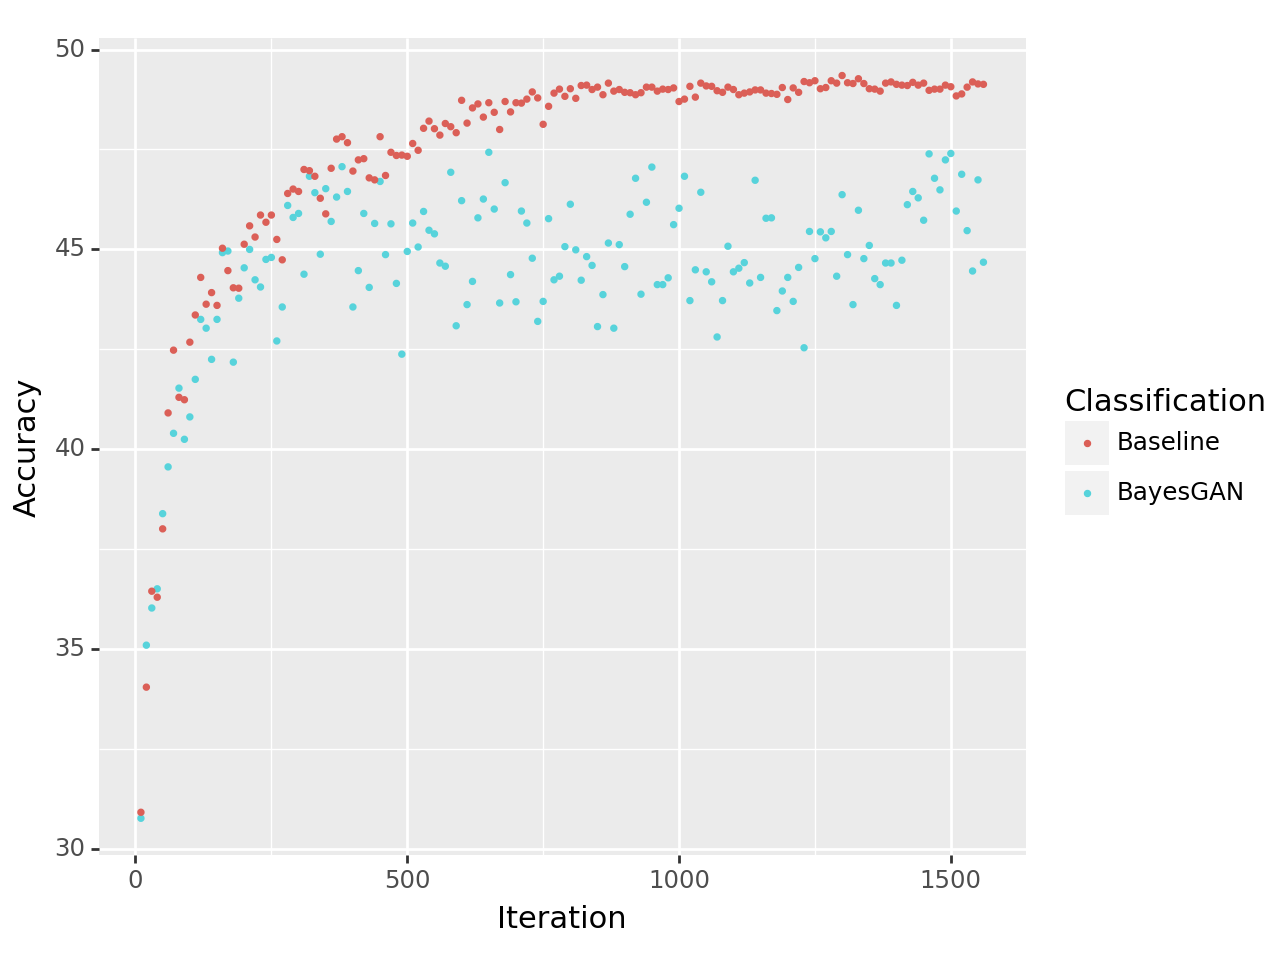

In [18]:
p = ggplot(df, aes(x='Iteration', y='Accuracy', color='Classification', label='Classification')) + geom_point(size=0.5)
print(p)

After training for 50 epochs, below are the samples generator by four different parameters $\theta_g$'s. Note that different parameters tend to have different artistic styles.

![Generated Samples Parameter 1](figs/fake_samples_epoch_024_G000.png)
![Generated Samples Parameter 2](figs/fake_samples_epoch_024_G001.png)
![Generated Samples Parameter 3](figs/fake_samples_epoch_024_G002.png)
![Generated Samples Parameter 4](figs/fake_samples_epoch_024_G003.png)

Note: This code is adapted from the implementation by Saatchai and Wilson in Tensorflow (https://github.com/andrewgordonwilson/bayesgan) and the DCGAN code from Pytorch examples (https://github.com/pytorch/examples/tree/master/dcgan).